In [1]:
import os
os.chdir("..")
#!pip install -r requirements.txt

### Библиотеки

In [2]:
import boto3
from dotenv import dotenv_values
import pandas as pd
from io import StringIO
import numpy as np
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format='retina'
sns.set_style("darkgrid")

from scipy.optimize import minimize, Bounds, LinearConstraint, NonlinearConstraint

from portfolio_analytics.optimizer import Optimizer
from portfolio_analytics.utils import plot_efficient_frontier_curve

import warnings
warnings.filterwarnings('ignore')

config = dotenv_values(".env")

### Данные с S3

In [3]:
session = boto3.session.Session()
s3 = session.client(
    service_name='s3',
    endpoint_url='https://storage.yandexcloud.net',
    aws_access_key_id = config['s3_aws_access_key_id'],
    aws_secret_access_key = config['s3_aws_secret_access_key']
)

In [4]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="prepared_data/test.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
stock_data=pd.read_csv(csv_data).iloc[:,1:]
stock_data = stock_data.ffill().bfill()
stock_data

,YRSB,ROSN,MTSS,RTKM,TATN,WTCMP,OGKB,SNGS,UTAR,LPSB,...,SBERP,NLMK,MGTSP,RZSB,RTSB,APTK,VSMO,VRSBP,PLZL,ASSB
0,19.200,227.74,374.75,291.87,154.60,7.00,3.6400,30.501,17.950,5.352,...,69.62,104.60,793.1,1.849,0.378,1779.000,7610.00,4.50,1153.00,0.600
1,19.200,230.60,373.88,292.00,153.50,7.00,3.5270,30.430,18.230,5.400,...,70.00,105.00,793.0,1.726,0.379,1795.000,7681.00,4.40,1207.00,0.649
2,19.200,223.38,374.95,295.50,154.22,7.00,3.5440,30.400,18.644,5.550,...,70.30,105.00,770.0,1.722,0.378,1770.000,7635.00,4.45,1208.00,0.649
3,19.050,224.00,379.80,299.00,158.50,7.00,3.5600,30.692,18.290,5.450,...,70.41,104.00,773.0,1.720,0.380,1755.000,7600.00,4.10,1254.00,0.660
4,20.882,221.98,374.90,301.49,157.44,6.90,3.5500,30.400,18.459,5.420,...,71.00,104.00,780.0,1.670,0.377,1755.000,7635.06,4.20,1277.78,0.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,706.000,581.95,196.45,58.46,629.20,10.24,0.3228,23.655,13.030,63.300,...,270.32,135.30,800.0,28.420,2.370,10.806,22740.00,128.00,13973.50,1.480
4252,690.000,579.10,196.00,59.27,630.90,10.26,0.3252,24.000,13.260,63.700,...,269.25,133.78,810.0,28.340,2.360,10.742,22180.00,127.80,14001.00,1.540
4253,698.000,591.00,196.00,59.97,635.80,10.20,0.3273,23.870,13.240,62.100,...,272.01,134.86,810.0,28.360,2.320,10.674,22200.00,125.40,14139.00,1.555
4254,694.000,596.00,202.00,61.62,652.40,10.30,0.3280,24.115,13.010,62.450,...,273.50,139.62,828.0,28.400,2.300,10.650,22460.00,127.00,13926.00,1.560


In [5]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="stock_meta_data.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
meta_data=pd.read_csv(csv_data).iloc[:,1:]
meta_data

,id,secid,shortname,regnumber,name,isin,is_traded,emitent_id,emitent_title,emitent_inn,emitent_okpo,gosreg,type,group,primary_boardid,marketprice_boardid
0,424433251,ABIO,iАРТГЕН ао,1-01-08902-A,"ПАО ""Артген""",RU000A0JNAB6,1,1142.0,"Публичное акционерное общество ""Артген биотех""",7.702509e+09,71328785.0,1-01-08902-A,common_share,stock_shares,TQBR,TQBR
1,12441,ABRD,АбрауДюрсо,1-02-12500-A,Абрау-Дюрсо ПАО ао,RU000A0JS5T7,1,4787.0,"Публичное акционерное общество ""Абрау – Дюрсо""",7.727621e+09,81521198.0,1-02-12500-A,common_share,stock_shares,TQBR,TQBR
2,2699,AFKS,Система ао,1-05-01669-A,"АФК ""Система"" ПАО ао",RU000A0DQZE3,1,777.0,"Публичное акционерное общество ""Акционерная фи...",7.703105e+09,27987276.0,1-05-01669-A,common_share,stock_shares,TQBR,TQBR
3,2700,AFLT,Аэрофлот,1-01-00010-A,Аэрофлот-росс.авиалин(ПАО)ао,RU0009062285,1,1242.0,"Публичное акционерное общество ""Аэрофлот – рос...",7.712040e+09,29063984.0,1-01-00010-A,common_share,stock_shares,TQBR,TQBR
4,76079,AGRO,AGRO-гдр,NaN,ГДР ROS AGRO PLC ORD SHS,US7496552057,1,7502.0,ROS AGRO PLC,1.003487e+07,NaN,NaN,depositary_receipt,stock_dr,TQBR,TQBR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2412,8151,ziop,"АО ""ЗиО-Подольск""",1-01-04090-A,"Акционерное общество ""Машиностроительный завод...",RU000A0JQ6B5,0,3685.0,"Акционерное общество ""Машиностроительный завод...",5.036041e+09,NaN,1-01-04090-A,common_share,stock_shares,EQNE,NaN
2413,7778,ZIRE,ЗИРЕРА ао,1-01-57303-D,"""ЗИРЕРА"" ОАО - ао",RU000A0JRFT8,0,4518.0,"Открытое акционерное общество ""ЗИРЕРА""",1.655203e+09,68734469.0,1-01-57303-D,common_share,stock_shares,TQNE,NaN
2414,3898,ZMZN,ЗМЗ-ао,1-01-00230-A,Заволжский мотор.з-д ПАО ао,RU0009101539,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,1-01-00230-A,common_share,stock_shares,TQBR,TQBR
2415,3899,ZMZNP,ЗМЗ-ап,2-01-00230-A,Заволжский мотор.завод ПАО ап,RU0006752854,0,1004.0,"Публичное акционерное общество ""Заволжский мот...",5.248004e+09,NaN,2-01-00230-A,preferred_share,stock_shares,TQBR,TQBR


### Доходности

In [6]:
stock_data

,YRSB,ROSN,MTSS,RTKM,TATN,WTCMP,OGKB,SNGS,UTAR,LPSB,...,SBERP,NLMK,MGTSP,RZSB,RTSB,APTK,VSMO,VRSBP,PLZL,ASSB
0,19.200,227.74,374.75,291.87,154.60,7.00,3.6400,30.501,17.950,5.352,...,69.62,104.60,793.1,1.849,0.378,1779.000,7610.00,4.50,1153.00,0.600
1,19.200,230.60,373.88,292.00,153.50,7.00,3.5270,30.430,18.230,5.400,...,70.00,105.00,793.0,1.726,0.379,1795.000,7681.00,4.40,1207.00,0.649
2,19.200,223.38,374.95,295.50,154.22,7.00,3.5440,30.400,18.644,5.550,...,70.30,105.00,770.0,1.722,0.378,1770.000,7635.00,4.45,1208.00,0.649
3,19.050,224.00,379.80,299.00,158.50,7.00,3.5600,30.692,18.290,5.450,...,70.41,104.00,773.0,1.720,0.380,1755.000,7600.00,4.10,1254.00,0.660
4,20.882,221.98,374.90,301.49,157.44,6.90,3.5500,30.400,18.459,5.420,...,71.00,104.00,780.0,1.670,0.377,1755.000,7635.06,4.20,1277.78,0.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4251,706.000,581.95,196.45,58.46,629.20,10.24,0.3228,23.655,13.030,63.300,...,270.32,135.30,800.0,28.420,2.370,10.806,22740.00,128.00,13973.50,1.480
4252,690.000,579.10,196.00,59.27,630.90,10.26,0.3252,24.000,13.260,63.700,...,269.25,133.78,810.0,28.340,2.360,10.742,22180.00,127.80,14001.00,1.540
4253,698.000,591.00,196.00,59.97,635.80,10.20,0.3273,23.870,13.240,62.100,...,272.01,134.86,810.0,28.360,2.320,10.674,22200.00,125.40,14139.00,1.555
4254,694.000,596.00,202.00,61.62,652.40,10.30,0.3280,24.115,13.010,62.450,...,273.50,139.62,828.0,28.400,2.300,10.650,22460.00,127.00,13926.00,1.560


In [7]:
ratio = (stock_data / stock_data.shift(1)).where(stock_data.shift(1) != 0, 1.0)
df_returns = np.log(ratio).iloc[1:,].reset_index(drop=True)
df_returns

,YRSB,ROSN,MTSS,RTKM,TATN,WTCMP,OGKB,SNGS,UTAR,LPSB,...,SBERP,NLMK,MGTSP,RZSB,RTSB,APTK,VSMO,VRSBP,PLZL,ASSB
0,0.000000,0.012480,-0.002324,0.000445,-0.007141,0.000000,-0.031536,-0.002331,0.015478,0.008929,...,0.005443,0.003817,-0.000126,-0.068838,0.002642,0.008954,0.009287,-0.022473,0.045771,0.078503
1,0.000000,-0.031810,0.002858,0.011915,0.004680,0.000000,0.004808,-0.000986,0.022456,0.027399,...,0.004277,0.000000,-0.029433,-0.002320,-0.002642,-0.014025,-0.006007,0.011300,0.000828,0.000000
2,-0.007843,0.002772,0.012852,0.011775,0.027374,0.000000,0.004505,0.009559,-0.019170,-0.018182,...,0.001563,-0.009569,0.003889,-0.001162,0.005277,-0.008511,-0.004595,-0.081917,0.037372,0.016807
3,0.091820,-0.009059,-0.012985,0.008293,-0.006710,-0.014389,-0.002813,-0.009559,0.009198,-0.005520,...,0.008345,0.000000,0.009015,-0.029501,-0.007926,0.000000,0.004603,0.024098,0.018786,-0.007605
4,0.024036,-0.041342,-0.045987,-0.008293,-0.058459,0.000000,-0.003103,-0.056153,-0.014185,-0.003697,...,-0.046855,-0.046547,0.000000,-0.001798,-0.018742,-0.028904,-0.019179,-0.024098,-0.045454,-0.053304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,0.011396,0.016023,0.008435,0.012739,0.006218,0.017734,0.012155,0.000634,0.009252,-0.003155,...,0.024643,0.012046,0.000000,0.023497,-0.020878,-0.013238,0.027643,0.023717,0.018381,0.006780
4251,-0.022924,-0.004909,-0.002293,0.013761,0.002698,0.001951,0.007407,0.014479,0.017498,0.006299,...,-0.003966,-0.011298,0.012423,-0.002819,-0.004228,-0.005940,-0.024935,-0.001564,0.001966,0.039740
4252,0.011528,0.020341,0.000000,0.011741,0.007737,-0.005865,0.006437,-0.005431,-0.001509,-0.025439,...,0.010199,0.008041,0.000000,0.000705,-0.017094,-0.006350,0.000901,-0.018958,0.009808,0.009693
4253,-0.005747,0.008425,0.030153,0.027142,0.025774,0.009756,0.002136,0.010212,-0.017524,0.005620,...,0.005463,0.034687,0.021979,0.001409,-0.008658,-0.002251,0.011644,0.012678,-0.015179,0.003210


### Анализ влияния ограничений в optimizer на границу эффективных портфелей

#### Задание 4

In [8]:
test_data_1_year = df_returns.iloc[:252,:]

#### Задание 5

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

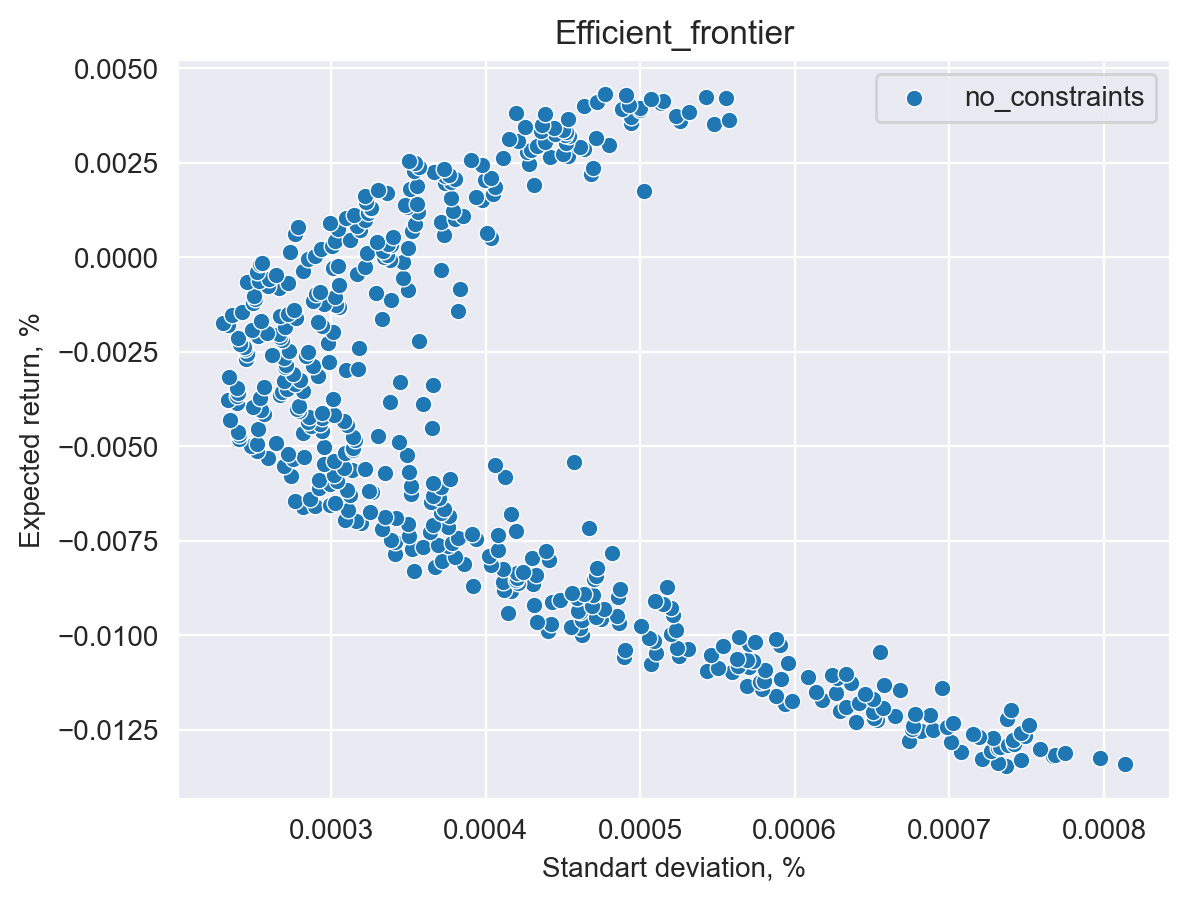

In [9]:
optim = Optimizer(test_data_1_year)
res_5 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)

#### Задание 6

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

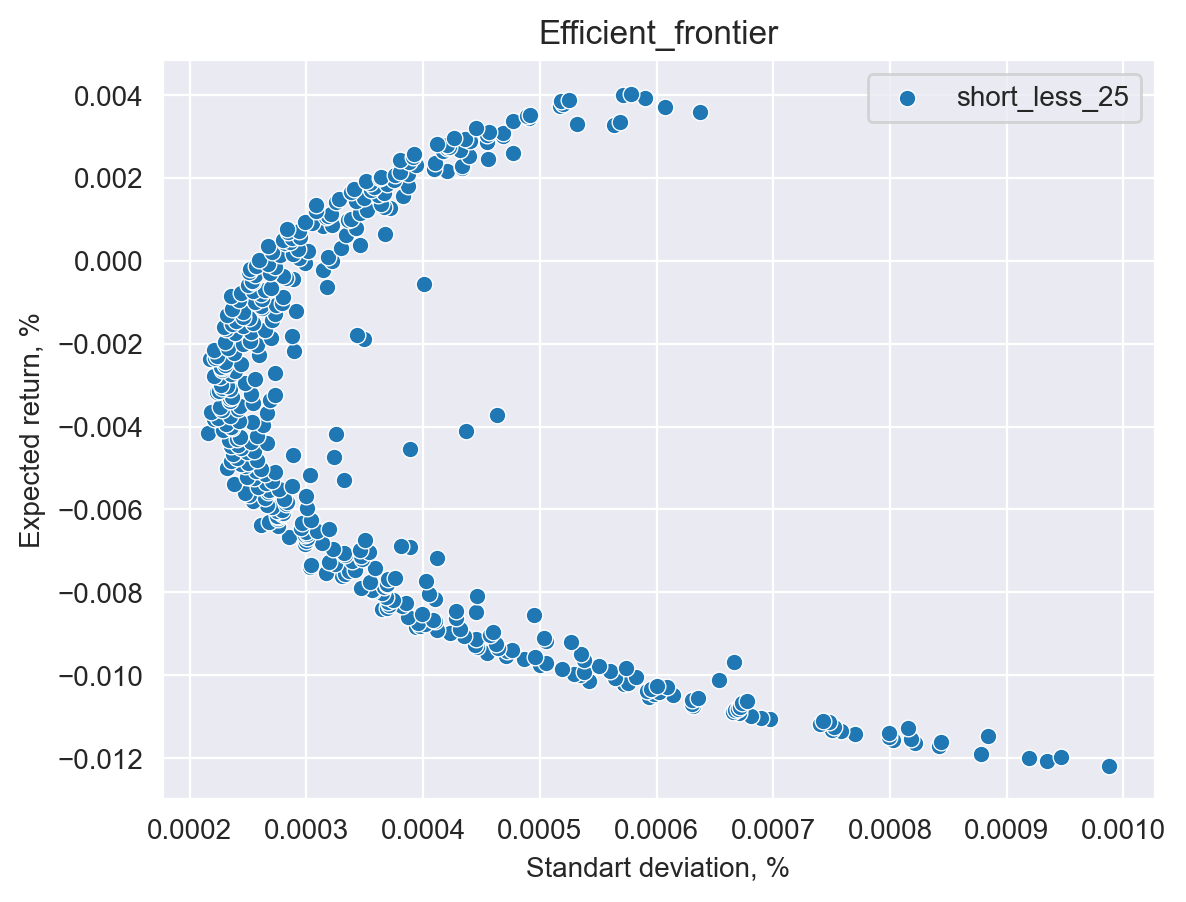

In [10]:
def sum_short(w):
    short_idx = np.where(w <= 0)
    total_short = np.sum(np.abs(w[short_idx]))
    return total_short

constr = [NonlinearConstraint(sum_short, 0.0, 0.25)]

optim = Optimizer(test_data_1_year, constrs=constr)
res_6 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)

#### Задание 7

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

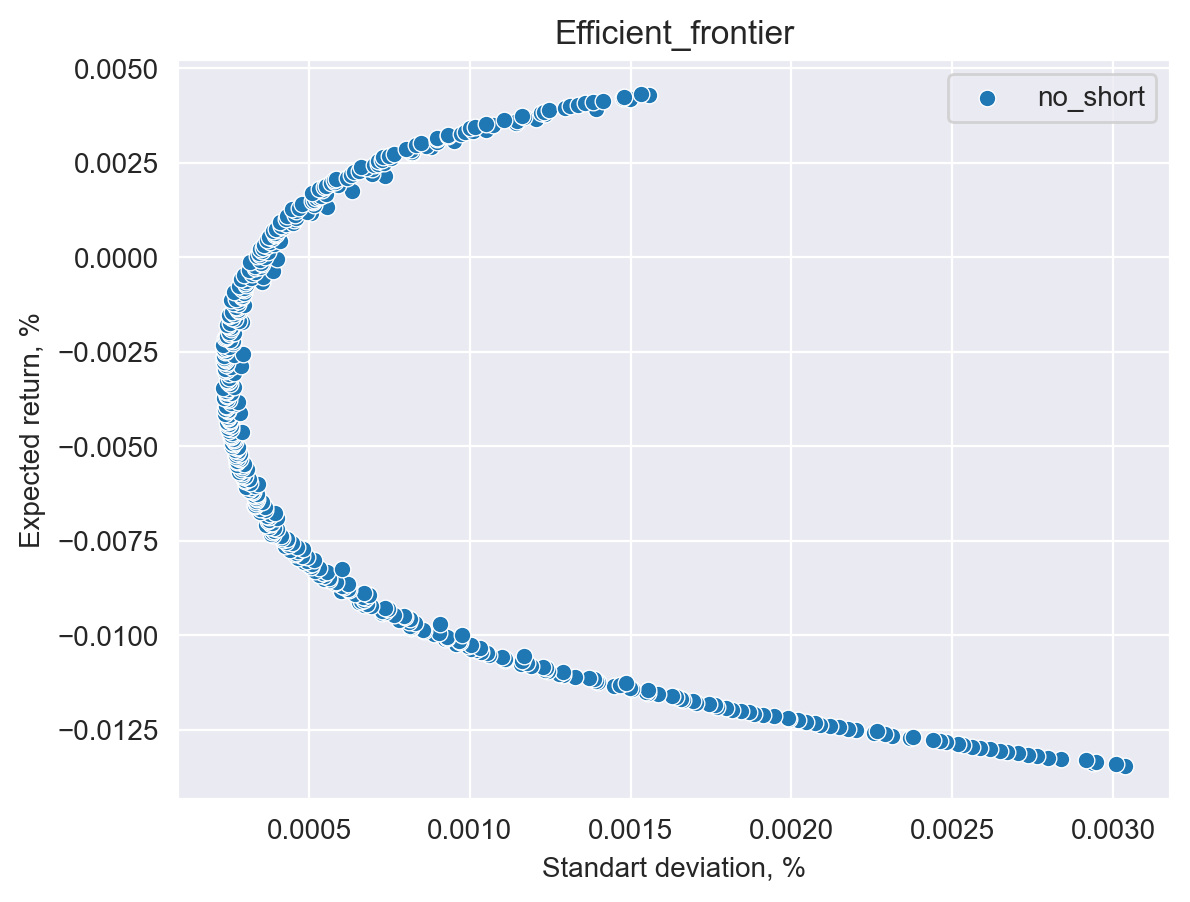

In [11]:
n_shares = test_data_1_year.shape[1]
no_short_bound = Bounds(np.zeros(n_shares), np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=no_short_bound)
res_7 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)

#### Задание 8

  0%|          | 0/500 [00:00<?, ?it/s]

<Figure size 800x800 with 0 Axes>

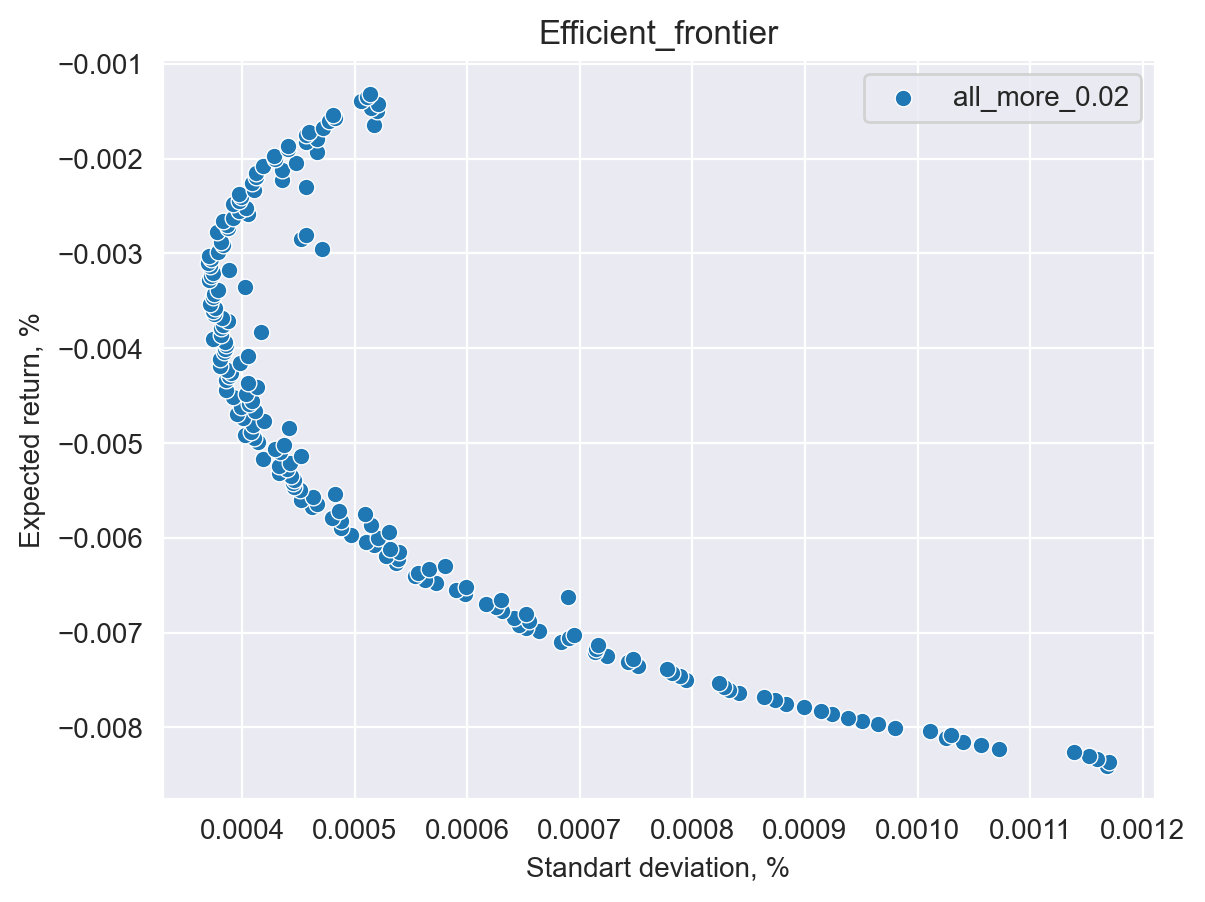

In [12]:
n_shares = test_data_1_year.shape[1]
min_bound = Bounds(np.zeros(n_shares)+0.02, np.ones(n_shares)) 

optim = Optimizer(test_data_1_year, bounds=min_bound)
res_8 = optim.efficient_frontier_curve()

plt.figure(figsize=(8,8))
fig, ax = plt.subplots()
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_0.02', ax=ax)

#### Задание 9

<Figure size 800x800 with 0 Axes>

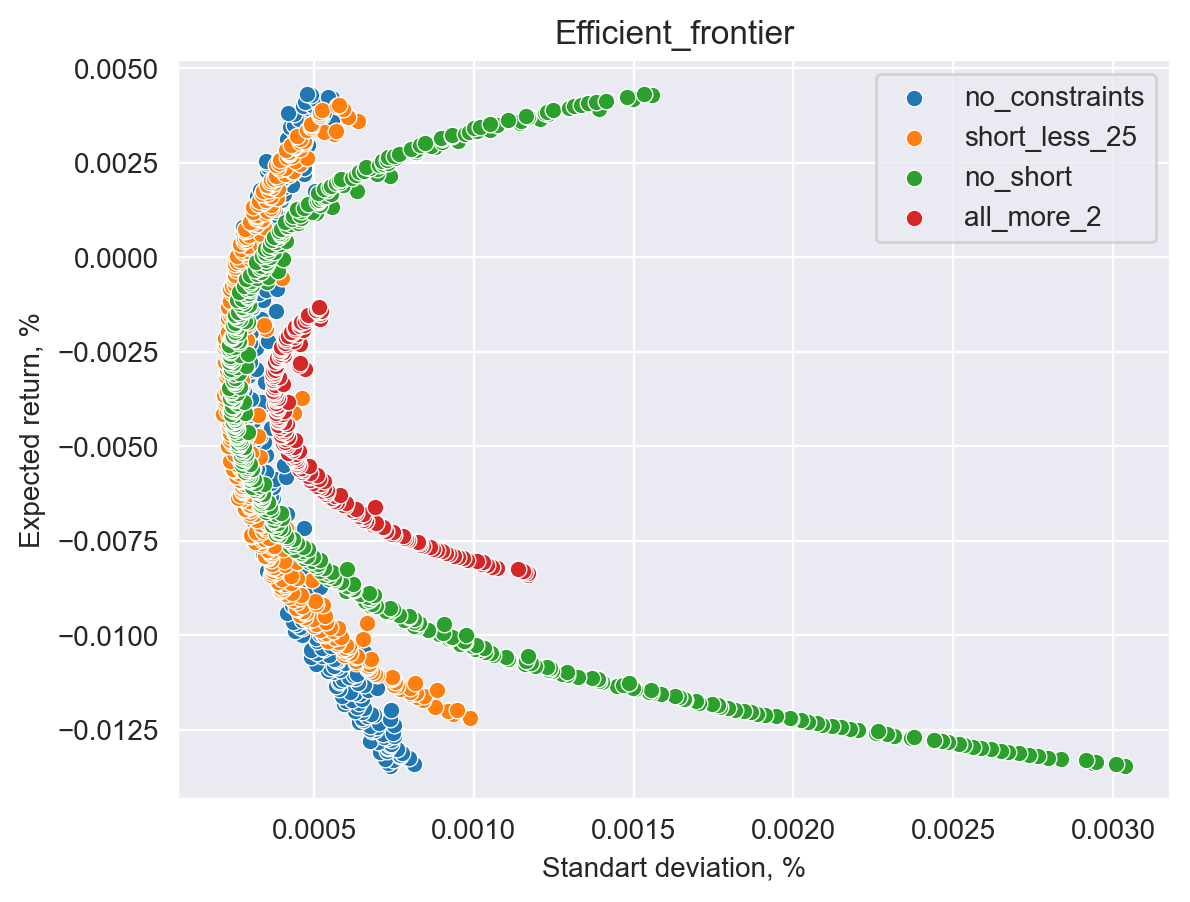

In [13]:
plt.figure(figsize=(8,8))
fig, ax = plt.subplots()

plot_efficient_frontier_curve([x[1] for x in res_5], [x[0] for x in res_5], label='no_constraints', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_6], [x[0] for x in res_6], label='short_less_25', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_7], [x[0] for x in res_7], label='no_short', ax=ax)
plot_efficient_frontier_curve([x[1] for x in res_8], [x[0] for x in res_8], label='all_more_2', ax=ax)

#### Задание 10

### Задание 11

In [ ]:
# index_data = pd.read_csv("IMOEX.csv", delimiter=';')
# csv_data = index_data.to_csv(index=False).encode('utf-8')
# s3.put_object(
#     Bucket='portfoliodata',
#     Key=f'IMOEX.csv',
#     Body=csv_data
# )

In [ ]:
bytes_data = s3.get_object(Bucket='portfoliodata', Key="IMOEX.csv")['Body'].read()
csv_data = StringIO(str(bytes_data,'utf-8')) 
stock_data=pd.read_csv(csv_data)#.iloc[:,1:]
stock_data = stock_data.ffill().bfill()
stock_data

,IMOEX
0,"1435,66"
1,"1480,73"
2,"1547,39"
3,"1515,37"
4,"1513,22"
...,...
2555,"3200,81"
2556,"3200,95"
2557,"3183,97"
2558,"3121,57"
